In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats import chi2_contingency, chi2 
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

In [2]:
file_name = 'group_add.csv'

def add_file(file_name ):
    home_directory = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-rom-fadeev/'
    
#     Предобработка DataFrame находящихся в домашней дирректории(эта часть кода должна быть вынесена во вне, но для удобства
#     внесена в  решение)_____________________________________________________________________________________

    groups = pd.read_csv(home_directory+'groups.csv', sep=" ")
    checks = pd.read_csv(home_directory+'checks.csv')
    active_studs = pd.read_csv(home_directory+'active_studs.csv')

    groups = groups.rename(columns={"id;grp": "idgrp"})
    groups[['id','grp']] = groups.idgrp.str.split(";",expand=True)
    groups.drop('idgrp', axis= 1 , inplace= True )
    groups = groups.rename(columns={'id': "student_id"})

    checks.columns
    checks = checks.rename(columns={'student_id;"rev"': "student_idrev"})
    checks[['student_id','rev']] = checks.student_idrev.str.split(";",expand=True)
    checks.drop('student_idrev', axis= 1 , inplace= True ) 
    checks['student_id'] = checks['student_id'].astype(int)
    checks_active_studs = active_studs.merge(checks, how='left', on='student_id')
    checks_active_studs = checks_active_studs.fillna(0)
    checks_active_studs['rev'] = checks_active_studs['rev'].astype(float)
# ______________________________________________________________________________________________________________

#   Получение и подготовка group_add.csv
    group_add = pd.read_csv(home_directory+file_name)
    group_add = group_add.rename(columns={'id': "student_id"})
    group_add['student_id'] = group_add['student_id'].astype(int)
    
#    Добавление вновь полученных данных со старыми 
    all_group = pd.concat([groups,group_add])
    all_group['student_id'] = all_group['student_id'].astype(int)

    

#     сводная таблица по всем пользователям 
    checks_active_studs_all_group1 = all_group.merge(checks_active_studs, how='left', on='student_id')
    checks_active_studs_all_group1 = checks_active_studs_all_group1.fillna(0)
    checks_active_studs_all_group1['rev'] = checks_active_studs_all_group1['rev'].astype(float)
    checks_active_studs_all_group1['student_id'] = checks_active_studs_all_group1['student_id'].astype(int)
#     все студенты по группам _____________________________________________________   
    all_users_AB = checks_active_studs_all_group1.groupby(['grp'], as_index=False).agg({'rev' : 'count'})
    
    
    
    
#      получаем всех купивших активных пользователей зашедших на платформу
    checks_active_studs_all_group2 = all_group.merge(checks_active_studs, how='inner', on='student_id')
#     Все активные студенты по группам__________________________________________ 
    all_active_users_AB = checks_active_studs_all_group2.groupby(['grp'], as_index=False).agg({'rev' : 'count'}) 
    
    
    
    
    
#     Всего купили и на платформе и вне ее 541___________________________________________________________
    checks_active_studs_all_group3 = checks_active_studs_all_group1.merge(checks, how='right', on='student_id')
    checks_active_studs_all_group3 = checks_active_studs_all_group3.rename(columns={"rev_x": "rev"})
    checks_active_studs_all_group3.drop('rev_y', axis= 1 , inplace= True )
    all_checks = checks_active_studs_all_group3.shape[0]    
#     Все купившие студенты группы АB _________________________________________  
    all_checks_users_AB = checks_active_studs_all_group3.groupby(['grp'], as_index=False).agg({'rev' : 'count'}) 
    
        
    
#     Всего активные и купили на платформе 392______________________________________________________
    checks_active_studs_all_group4 =checks_active_studs_all_group2.query('rev != 0')
    all_checks_active_by_groups = checks_active_studs_all_group2.query('rev != 0').shape[0]
#   Все купившие активные студенты группы АB _______________________________  
    all_active_checks_users_AB = checks_active_studs_all_group4.groupby(['grp'], as_index=False).agg({'rev' : 'count'}) 
     
    
    #     общий доход по всем покупкам по группам                                 
    all_revenue_AB =checks_active_studs_all_group3.groupby(['grp'], as_index=False).agg({'rev' : 'sum'})

    
    #     общий доход по активным покупкам по группам                          
    all_active_revenue_AB =checks_active_studs_all_group4.groupby(['grp'], as_index=False).agg({'rev' : 'sum'})
    

#     ВЫвод:
#     all_revenue_AB = all_active_revenue_AB - это означает, что 541-392 = 149 - оплативших либо вернули деньги либо оплатили 
#     иным способом(не через платформу), либо данные о сумме полученой от 149 оплативших утеряны
    

    res1 = all_users_AB.merge(all_active_users_AB, how='outer', on='grp')
    res1 = res1.rename(columns={'rev_x': "all_st", 'rev_y': "all_active_st"})
    res2 = res1.merge(all_checks_users_AB, how='outer', on='grp')
    res2 = res2.rename(columns={'rev': "all_check_st"})
    res3 = res2.merge(all_active_checks_users_AB, how='outer', on='grp')
    res3 = res3.rename(columns={'rev': "all_active_check_st"})
    res4 = res3.merge(all_revenue_AB, how='outer', on='grp')
    
 # ARPU считается относительно всех пользователей, попавших в группы.

 # ARPAU (Average Revenue Per Active User) - средний платеж на всех активных пользователей.

 # CR = (Количество совершивших целевое действие / Количество посетителей или пользователей) 
 # Количество посетителей — это общее число посетителей или пользователей, которые видели маркетинговую кампанию или страницу.
    res4['ARPU'] = res4['rev']/ res4['all_st']
    res4['ARPAU'] = res4['rev']/ res4['all_active_st']
    res4['CR'] = res4['all_active_check_st']/ res4['all_active_st']

    return res4[['grp', 'ARPU', 'ARPAU', 'CR']]

add_file(file_name)




/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,grp,ARPU,ARPAU,CR
0,A,4.956102,47.347204,0.050715
1,B,6.595762,58.058798,0.046156


In [3]:
met = add_file(file_name)

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


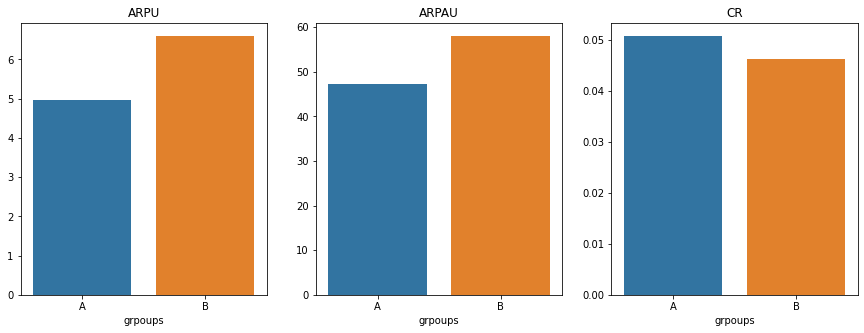

In [4]:
def visual_by_metric(df):

    fig, ax = plt.subplots(1, 3, figsize=[15, 5])
    sns.barplot(ax=ax[0], data=df, x='grp', y='ARPU').set(xlabel='grpoups', ylabel='', title='ARPU'),
    sns.barplot(ax=ax[1], data=df, x='grp', y='ARPAU').set(xlabel='grpoups', ylabel='', title='ARPAU'),
    sns.barplot(ax=ax[2], data=df, x='grp', y='CR').set(xlabel='grpoups', ylabel='', title='CR')
    
    
visual_by_metric(met)